# ECS171 Final Group Project: Pizza/Not Pizza Image Classifier


## Step 1: Data Exploration
Goals for this portion of the project:
+ Data evaluation
    + Evaluate all of the photos in the dataset, cull outliers
+ Number of total observations
    + Number and list of classes, plot class data
+ Image specifications
    + Total number of images
    + Image dimensions, and whether they need to be processed to be standardized

Preliminary data evaluation:
- The pizza directory also includes images of primarily people eating pizza (and one singular photo of a baby), and not the actual food itself; they've been culled before we imported the data.
- Data cannot be downloaded from Kaggle without an account; the data has been downloaded and stored in the GitHub repo instead to simplify the process of importing the repo and directly using this notebook, at the cost of storage space (however, the data is only ~100 MB unpacked).

In [5]:
# Library imports
# The standard ones.
import numpy as np
import matplotlib.pyplot as plt
# Use the built-in Keras utilities for image imports
# The TensorFlow version will provide additional support
import tensorflow as tf
from tensorflow import keras

Found 1962 files belonging to 2 classes.


2022-12-04 15:05:50.699700: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


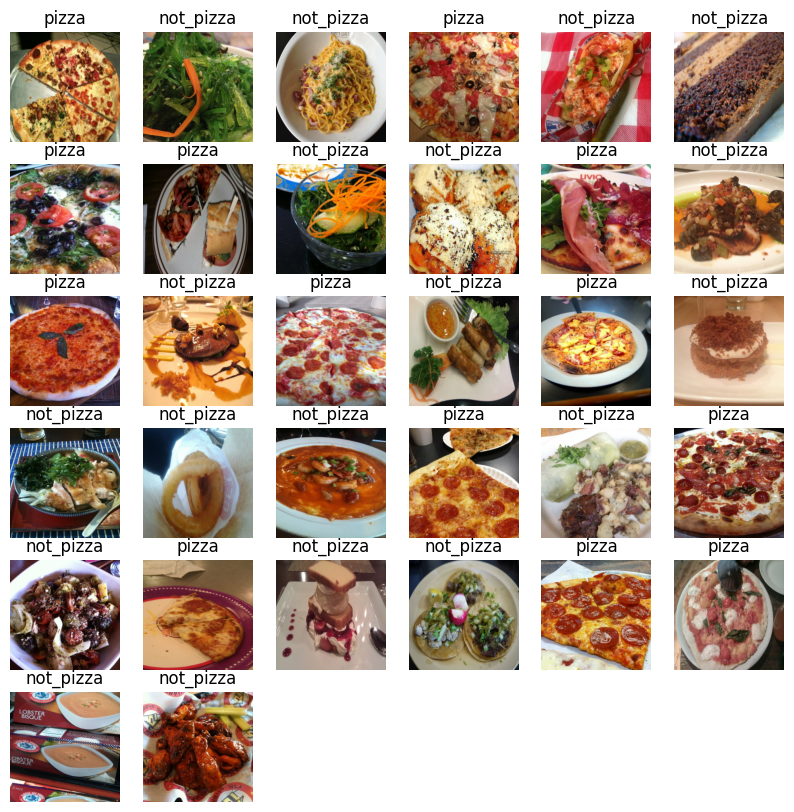

In [4]:
# Based on the docs, this will infer class type from directory structure.
# From the data directory, import the images with binary numeric labels and convert to RGB (f not already)
data = tf.keras.utils.image_dataset_from_directory("pizza_not_pizza", labels='inferred', label_mode='binary', color_mode='rgb')

# Following code is modified from https://www.tensorflow.org/tutorials/load_data/images#visualize_the_data
plt.figure(figsize=(10, 10))
class_names = data.class_names
for images, labels in data.take(1):
    for i in range(32): # Batch size is default of 32
        ax = plt.subplot(6, 6, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.array(labels[i])[0])])
        plt.axis("off")

Members of not_pizza: 983
Members of pizza: 979
Total # of classes: 2


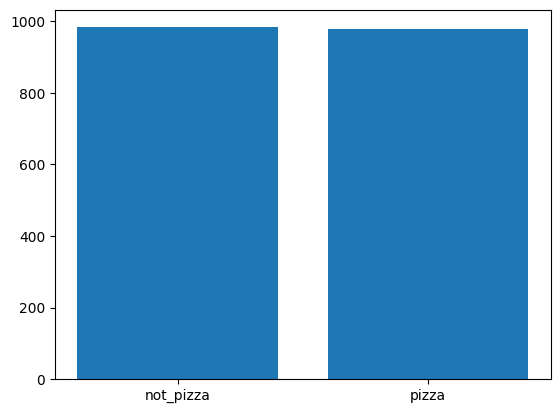

In [6]:
# Per the documents, there doesn't seem to be an easy way to get # of images per class from the dataset.
# Therefore, we can just do it ourselves the hard way — this solution assumes the OS library cannot be used.

plotLabel = [0, 0] # Not pizza, pizza
# Get all the file paths
fp = np.array(data.file_paths)
# Cull the parent directory from each string
fp = [i[16:] for i in fp]
for i in range(len(fp)):
    if fp[i].find("not_pizza") != -1:
        plotLabel[0] += 1
    else:
        plotLabel[1] += 1

plt.bar(class_names, plotLabel)
print("Members of " + class_names[0] + ": " + str(plotLabel[0]))
print("Members of " + class_names[1] + ": " + str(plotLabel[1]))
print("Total # of classes: " + str(len(class_names)))

### Image specifications
- Per the original dataset, there were 983 images of both pizza and non-pizza, meaning that the original set had a total of 1,966 photos. After our outlier check, there are now only 979 images of pizza, meaning we're currently working with 1,962 images. Furthermore, all provided photos have been resized such that one dimension of either width or height is 512 pixels, but wildly vary in the other dimension; the most consistent aspect ratio being square 1:1 photos. In this case, we can either choose to keep Keras' perservation of the full image with aspect ratio distortion, or enable cropping of the photo on import.

## Step 2: Pre-Processing
Goals for this portion of the project:
+ Image Processing
	+ Crop/resize all images to standard/downsampled size
	+ Pixel normalization/standardization for CNN input
	+ Image flattening

Found 1962 files belonging to 2 classes.


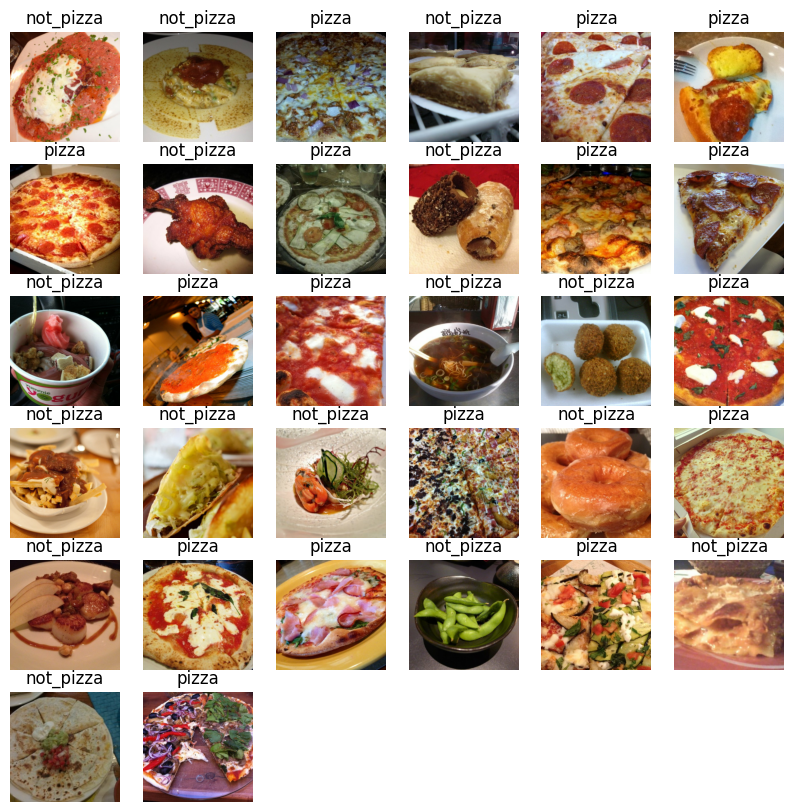

In [7]:
# We can perform point 1 by setting hyperparameter crop_to_aspect_ratio as true upon importing the data
# We can also resize by specifying the hyperparameter image_size, although this is done by default at 256x256
newData = tf.keras.utils.image_dataset_from_directory(
    "pizza_not_pizza",
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    crop_to_aspect_ratio = True)

plt.figure(figsize=(10, 10))
class_names = newData.class_names
for images, labels in newData.take(1):
    for i in range(32): # Batch size is default of 32
        ax = plt.subplot(6, 6, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.array(labels[i])[0])])
        plt.axis("off")
        
# From the documents, we can implement a standardization layer in the model such that we don't have to pre-process beforehand
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

# Flattening does not seem strictly necessary if we simply create the model with the raw pictures per the documents

## Step 3: Model Creation

Goals for this portion of the project:

+ Create a model
	+ Split the data into training/testing batches
	+ Create a basic convolutional neural network via Keras
+ Evaluate the model's performance
	+ Comparison of training versus testing performance
	+ Evaluate fit against fitting graph?

Further goals beyond 11/27:
+ Tweak model to increase accuracy/precision/recall
	+ More layers? Different hyperparameters?
	+ Consider if reevaluation and reprocessing of data necessary?
	+ Data augmentation implementation in order to improve performance?

In [8]:
# Implement an 80/20 train/test split
# Important to note that this splits our batches, rather than the images themselves, cleanly in 80/20
train_data, test_data = tf.keras.utils.split_dataset(newData, left_size = 0.8, shuffle = True, seed = 21)
# Tune the datasets for performance optimization per the documentation
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size = AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size = AUTOTUNE)

In [125]:
from tensorflow.keras.models import Sequential

# For our first model, we'll try something like the models in the 
# TensorFlow docs + the basic convolutional model from HW2.
model = tf.keras.Sequential([
  normalization_layer, # The normalizer/standardizer layer from pre-processing section
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (256, 256, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dropout(0.1),


  tf.keras.layers.Dense(1, activation="sigmoid")
])

# From the referenced Medium article, use the Adam optimizer 
# and binary cross-entropy, since we're making a binary classifier.
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

# Ten epochs due to the speed of training
trainHistory = model.fit(train_data, batch_size=32, epochs = 10)

Epoch 1/10
50/50 [==============================] - 18s 357ms/step - loss: 0.7424 - accuracy: 0.5554
Epoch 2/10
50/50 [==============================] - 17s 349ms/step - loss: 0.6568 - accuracy: 0.6210
Epoch 3/10
50/50 [==============================] - 17s 347ms/step - loss: 0.6198 - accuracy: 0.6924
Epoch 4/10
50/50 [==============================] - 17s 347ms/step - loss: 0.5758 - accuracy: 0.7140
Epoch 5/10
50/50 [==============================] - 17s 347ms/step - loss: 0.5502 - accuracy: 0.7306
Epoch 6/10
50/50 [==============================] - 17s 344ms/step - loss: 0.4873 - accuracy: 0.7713
Epoch 7/10
50/50 [==============================] - 17s 344ms/step - loss: 0.4269 - accuracy: 0.8140
Epoch 8/10
50/50 [==============================] - 17s 345ms/step - loss: 0.3508 - accuracy: 0.8522
Epoch 9/10
50/50 [==============================] - 17s 350ms/step - loss: 0.3167 - accuracy: 0.8720
Epoch 10/10
50/50 [==============================] - 17s 348ms/step - loss: 0.2675 - accura

### Model Evaluation

In [126]:
y_predTrain = [] # store predicted labels
y_trueTrain = [] # store true labels
y_predTest = []
y_trueTest = []

# Loop over the data, pull its true label and its predicted label into respective arrays
# Use verbose = 0 to surpress Keras output while we do this
for images, labels in train_data:
    y_trueTrain.append(np.where(labels > 0.5, 1, 0))
    y_predTrain.append(np.where(model.predict(images, verbose = 0) > 0.5, 1, 0))
for images, labels in test_data:
    y_trueTest.append(np.where(labels > 0.5, 1, 0))
    y_predTest.append(np.where(model.predict(images, verbose = 0) > 0.5, 1, 0))
    
# Concatenate the resulting arrays
y_predTrain = tf.concat(y_predTrain, axis=0)
y_trueTrain = tf.concat(y_trueTrain, axis=0)
y_predTest = tf.concat(y_predTest, axis=0)
y_trueTest = tf.concat(y_trueTest, axis=0)

Training Data

              precision    recall  f1-score   support

   Not Pizza       0.89      0.99      0.94       786
       Pizza       0.99      0.88      0.93       784

    accuracy                           0.94      1570
   macro avg       0.94      0.94      0.94      1570
weighted avg       0.94      0.94      0.94      1570



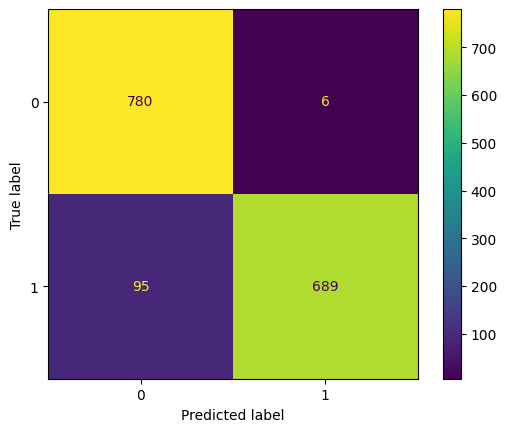

In [127]:
# Create confusion matrices and classification reports to visualize categorizations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print("Training Data\n")
cm1 = confusion_matrix(y_trueTrain, y_predTrain)
cm_display1 = ConfusionMatrixDisplay(cm1).plot()
print(classification_report(y_trueTrain, y_predTrain, target_names = ["Not Pizza", "Pizza"]))

Testing Data

              precision    recall  f1-score   support

   Not Pizza       0.67      0.83      0.74       197
       Pizza       0.77      0.59      0.67       195

    accuracy                           0.71       392
   macro avg       0.72      0.71      0.71       392
weighted avg       0.72      0.71      0.71       392



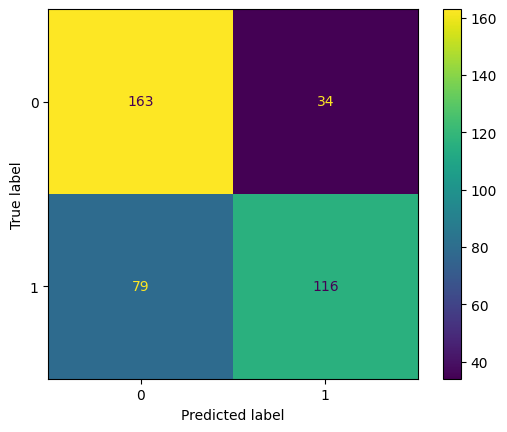

In [128]:
print("Testing Data\n")
cm2 = confusion_matrix(y_trueTest, y_predTest)
cm_display2 = ConfusionMatrixDisplay(cm2).plot()
print(classification_report(y_trueTest, y_predTest, target_names = ["Not Pizza", "Pizza"]))

In [129]:
# Use the evaluate function to evaluate how well our model does with training vs. testing data
# Accuracy should agree (to 0.1%) with that calculated for confusion matrices / classification reports
trainMetrics = model.evaluate(train_data, verbose = 0)
testMetrics = model.evaluate(test_data, verbose = 0)
print("Training data performance:\nLoss: %.2f\nAccuracy: %.2f\n" % (trainMetrics[0], trainMetrics[1]))
print("Testing data performance:\nLoss: %.2f\nAccuracy: %.2f" % (testMetrics[0], testMetrics[1]))

Training data performance:
Loss: 0.21
Accuracy: 0.94

Testing data performance:
Loss: 0.61
Accuracy: 0.71


### Model Fit Evaluation
![Model complexity graph](notebook_resources/model-fit-graph.png)

Based on the high loss and low accuracy of the testing data in comparison to the low loss and high accuracy of the training data, we can very safely say that our model is overfit to the training data, and is thus skewed towards the right-most end of the model complexity graph. 

### References for this section
+ https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb
+ https://www.researchgate.net/figure/Model-complexity-and-prediction-error_fig1_339913183
+ https://stackoverflow.com/a/68927032
+ https://stackoverflow.com/a/73215222